In [5]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import pandas as pd
import bioread
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.signal import find_peaks

In [6]:
def FPM(nombreArchivo):
    # Leer el archivo de datos
    señal = np.loadtxt(nombreArchivo)
    N = len(señal); n = np.arange(N) 
    


    # Elimino tendencia -----------------------------------------------------------------------------
    A3 = np.arange(0,N,250) #arreglo
    B3 = tuple(A3) #tupla
    señal_sin_tendencia = signal.detrend(señal,bp=A3)
    #------------------------------------------------------------------------------------------------



    M = np.arange (2,6,1) #vector de ordenes de los FPM
    k = np.arange (0,30,dtype=np.float64)

    resp = np.empty ((N,len(M)))

    for i,N1 in enumerate (M):
        FPM = np.piecewise (k,(0<=k)&(k<=N1-1),[1/N1,0])
        resp[:,i] = np.convolve (señal_sin_tendencia,FPM,"same")


    peaks_max = find_peaks (señal_sin_tendencia,distance=150)[0]
    peaks_min = find_peaks (-señal_sin_tendencia,distance=150)[0]
    
    A_max_signal = np.mean (señal_sin_tendencia[peaks_max])
    A_min_signal = np.mean (señal_sin_tendencia[peaks_min])

    aux_max = np.zeros ((len(M),len(peaks_max)))
    aux_min = np.zeros ((len(M),len(peaks_min))) 

    for i in range  (len(M)):
        peaks2_max = find_peaks (resp[:,i],distance=150)[0]
        peaks2_min = find_peaks (-resp[:,i],distance=150)[0]
        aux_max [i,:] = resp [peaks2_max,i]
        aux_min [i,:] = resp [peaks2_min,i]
    A_max = np.mean (aux_max,axis=1) ; A_min = np.mean (aux_min,axis=1)
    A_signal = A_max_signal - A_min_signal ; A_signal_filtr = A_max - A_min
    Atenuac = np.round ((A_signal - A_signal_filtr)*100/A_signal,1) #porcentaje de atencuación


    max_noise = np.zeros (len(M)) ; min_noise = np.zeros (len(M))
    for i in range (len(M)):
        max_noise[i] = max(resp[400:600,i]) #ruido uniforme en toda la señal
        min_noise[i] = min(resp[400:600,i])


    A_noise = max_noise - min_noise
    SNR = A_signal_filtr / A_noise
    SNR_dB = 20*np.log (A_signal_filtr/A_noise)
    
    for i in range (len(M)):
        if (Atenuac[i] < 20)&(SNR_dB[i] == max(SNR_dB)):
            print (f"El filtro de orden {M[i]} posee una atenuación de {Atenuac[i]} y una SNR de {SNR_dB[i]} dB.")
            Mejor_FPM = i

    plt.figure(figsize=(20,8))
    plt.title (( 'FPM de orden = ', M[Mejor_FPM] ))
    plt.plot(n, señal_sin_tendencia,color="y")
    plt.plot(n, resp[:,Mejor_FPM],color="k")
    plt.grid (True)
    plt.show()

El filtro de orden 3 posee una atenuación de 19.1 y una SNR de 32.55283182381289 dB.


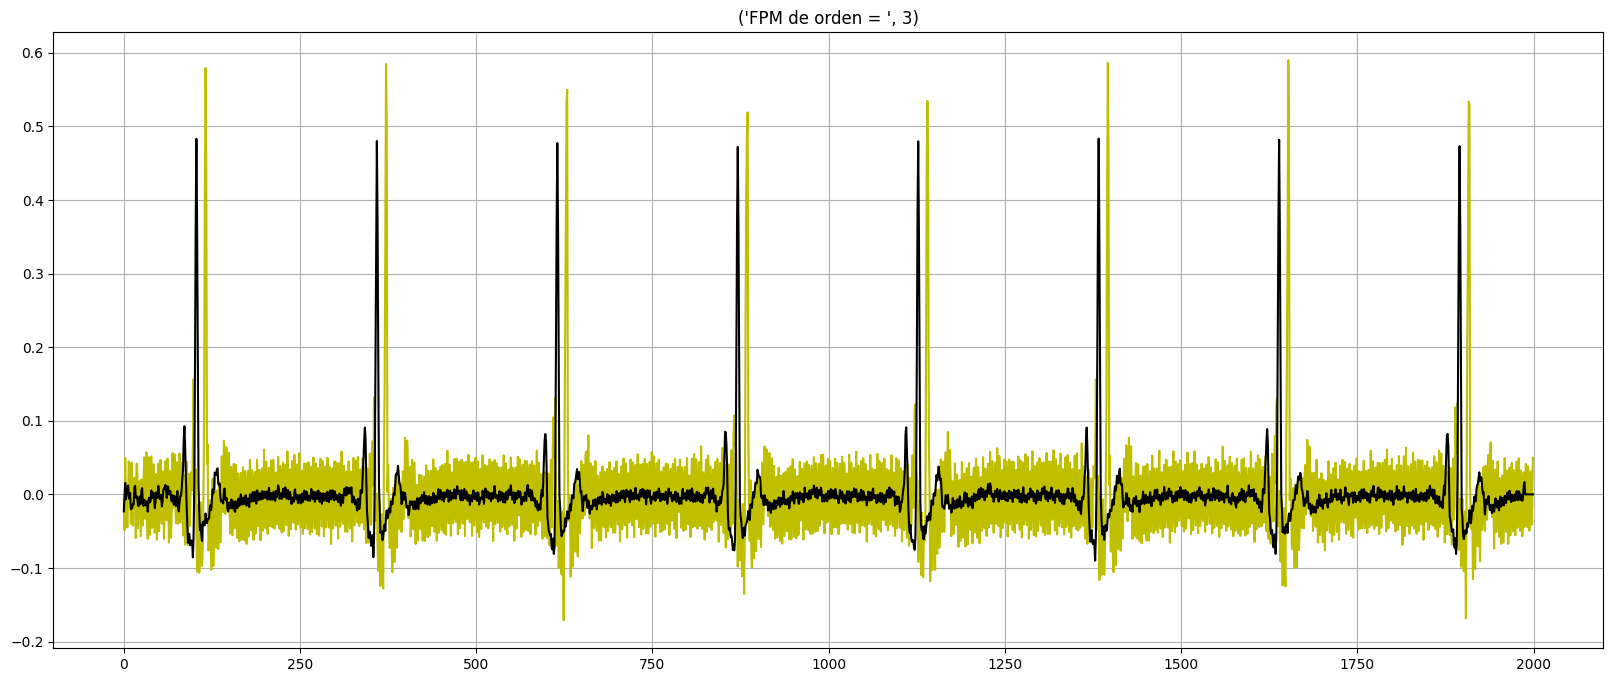

In [7]:
FPM ("/Users/paulaaguirrecarol/Desktop/PDSB 1/ECG10.txt")

In [8]:
import bioread

Canal 0: Channel ECG (.05 - 150 Hz): 20167 samples, 1000.0 samples/sec, loaded: True


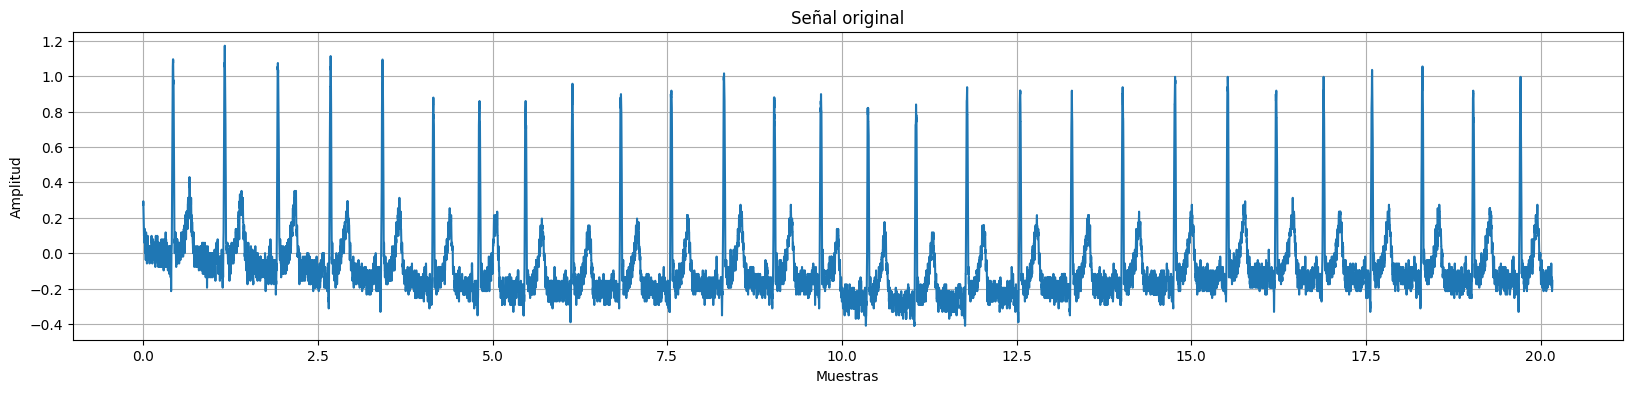

In [15]:
ECG = bioread.read_file ("/Users/paulaaguirrecarol/Desktop/PDSB 1/2. ecg_sinf.acq")
canales = ECG.channels
for i in np.arange (0,len(canales)):
    print (f"Canal {i}: {canales[i]}")
    

canal_elegido = int (input ("Ingrese el canal que desea analizar:"))
t = ECG.time_index.T

señal = ECG.channels[canal_elegido].data
Fs = ECG.channels[canal_elegido].samples_per_second
N = len(señal)

# Graficar la señal original
plt.figure (figsize=(20,4))
plt.plot (t, señal)
plt.title ( 'Señal original' )
plt.xlabel ( 'Muestras' )
plt.ylabel ( 'Amplitud' )
plt.grid ()
plt.savefig('/Users/paulaaguirrecarol/Desktop/Proyecto Final/imagenes/senalGeneradaACQ.jpg', dpi=600, bbox_inches='tight')
plt.show ()

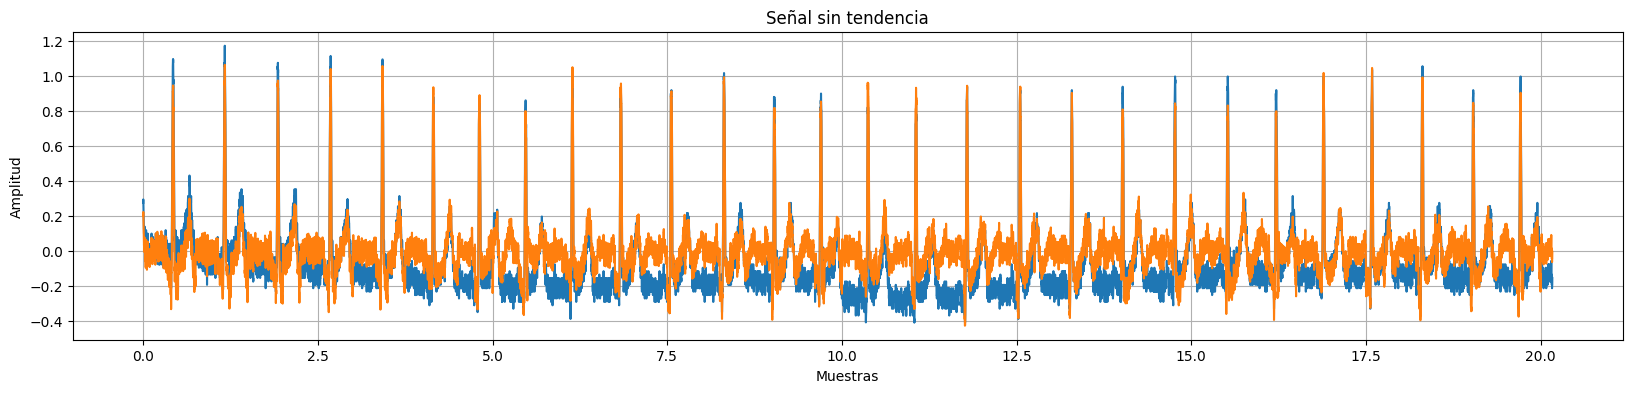

In [16]:
A3 = np.arange(0,N,250) #arreglo
B3 = tuple(A3) #tupla
señal_sin_tendencia = signal.detrend(señal,bp=A3)

# Graficar la señal sin tendencia
plt.figure (figsize=(20,4))
plt.plot (t, señal)
plt.plot (t, señal_sin_tendencia)
plt.title ( 'Señal sin tendencia' )
plt.xlabel ( 'Muestras' )
plt.ylabel ( 'Amplitud' )
plt.grid ()
plt.savefig('/Users/paulaaguirrecarol/Desktop/Proyecto Final/imagenes/senalSinTendenciaACQ.jpg', dpi=600, bbox_inches='tight')

El filtro de orden 5 posee una atenuación de 4.4 y una SNR de 0.21164853024022157 dB.
[ 4.4  8.1 12.3 17.7]
[ 0.21164853 -0.02352463 -0.11165212 -0.06953093]


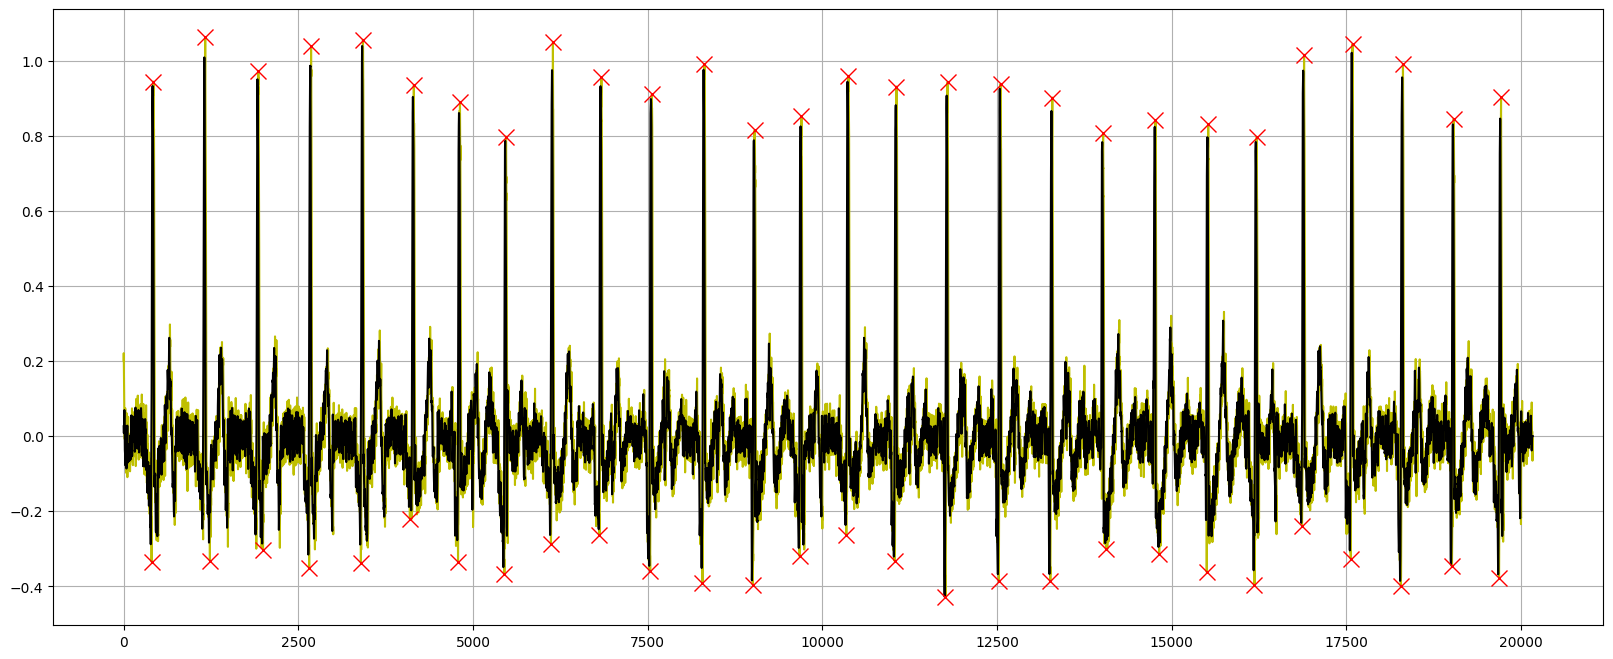

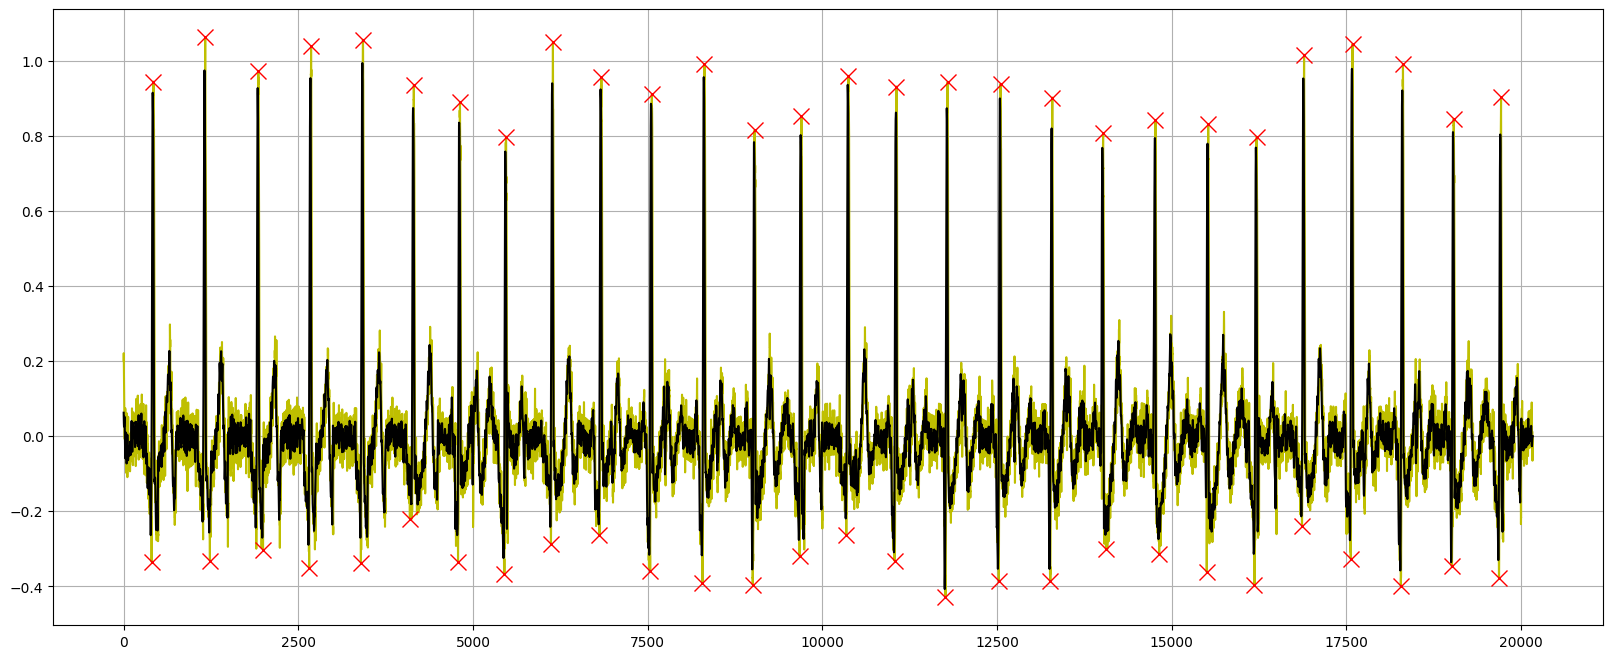

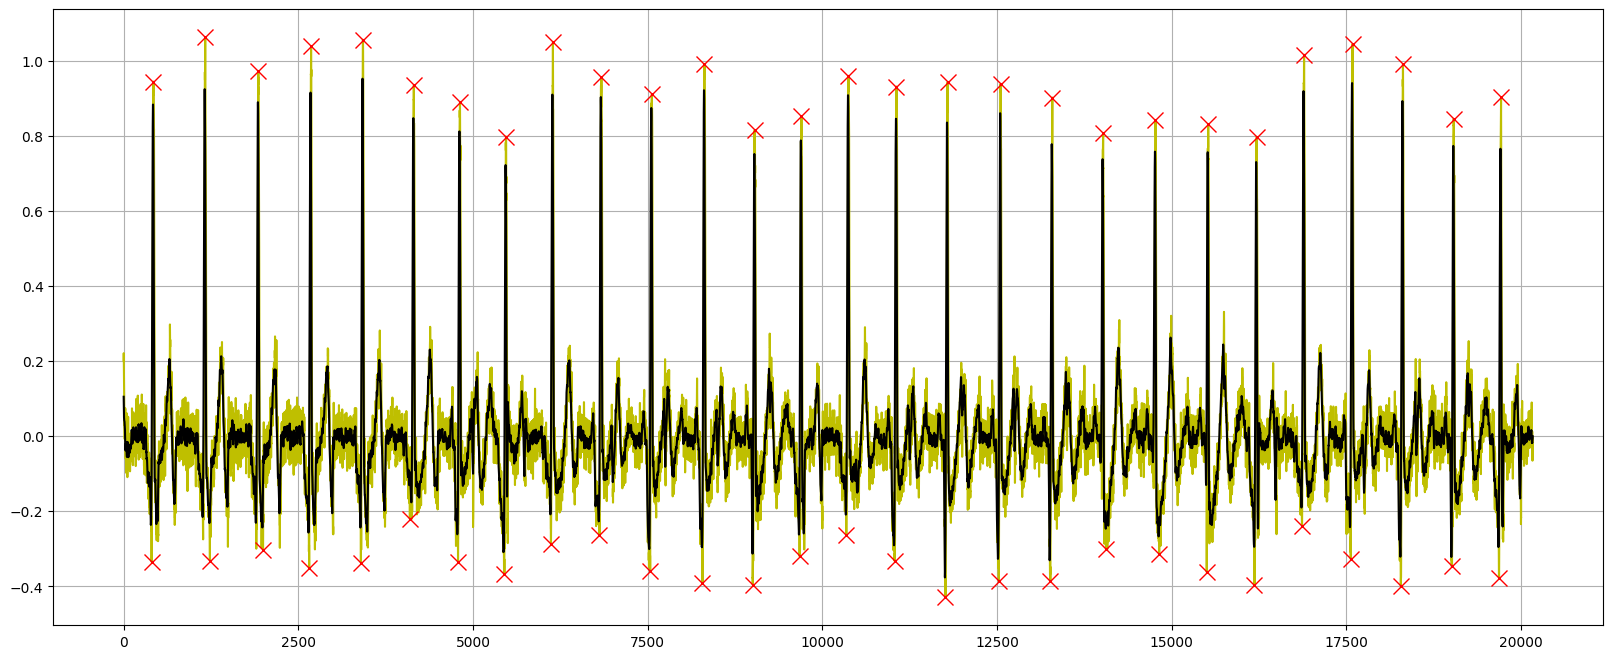

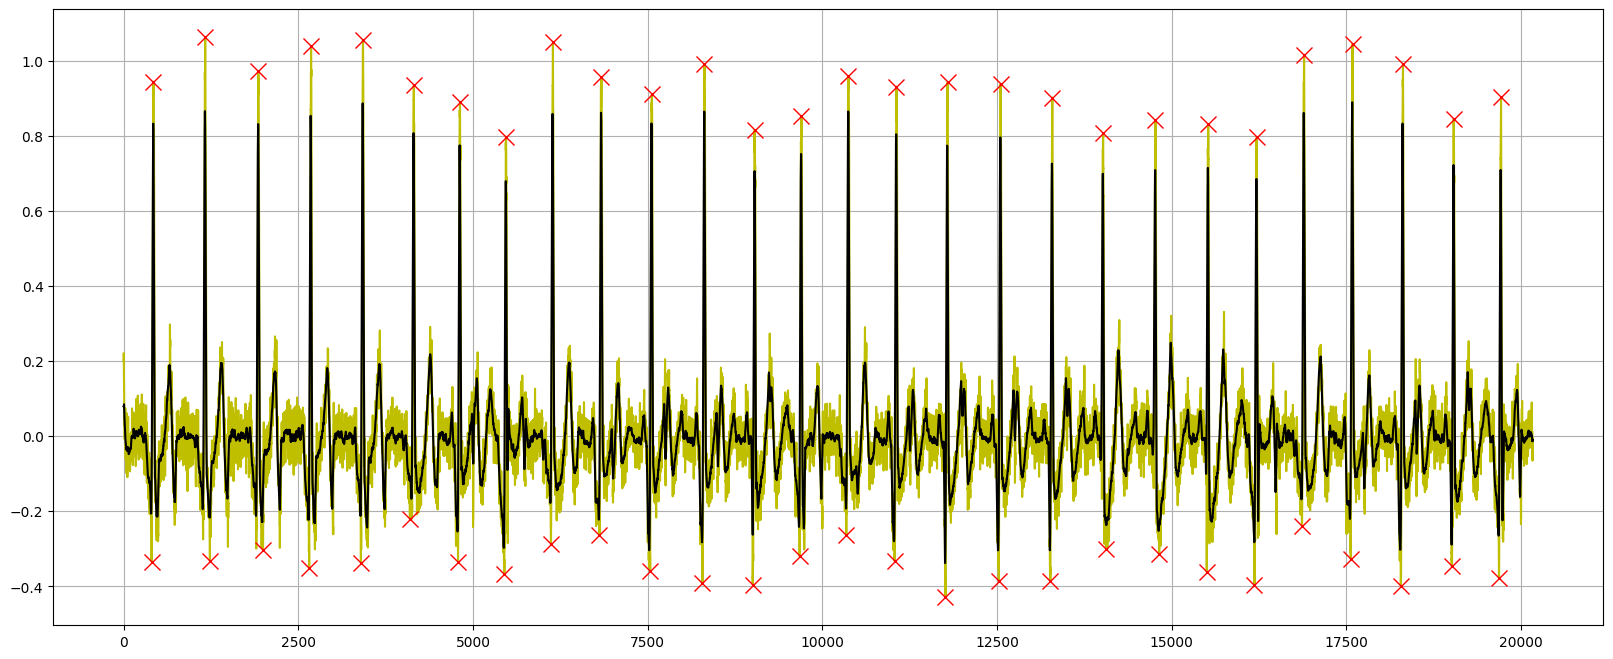

In [20]:
M = np.arange (5,25,5) #vector de ordenes de los FPM
k = np.arange (0,30,dtype=np.float64)

resp = np.empty ((N,len(M)))

for i,N1 in enumerate (M):
    FPM = np.piecewise (k,(0<=k)&(k<=N1-1),[1/N1,0])
    resp[:,i] = np.convolve (señal_sin_tendencia,FPM,"same")


peaks_max = find_peaks (señal_sin_tendencia,distance=500)[0]
peaks_min = find_peaks (-señal_sin_tendencia,distance=500)[0]
    
A_max_signal = np.mean (señal_sin_tendencia[peaks_max])
A_min_signal = np.mean (señal_sin_tendencia[peaks_min])

aux_max = np.zeros ((len(M),len(peaks_max)))
aux_min = np.zeros ((len(M),len(peaks_min))) 

for i in range  (len(M)):
    peaks2_max = find_peaks (resp[:,i],distance=500)[0]
    peaks2_min = find_peaks (-resp[:,i],distance=500)[0]
    aux_max [i,:] = resp [peaks2_max,i]
    aux_min [i,:] = resp [peaks2_min,i]
A_max = np.mean (aux_max,axis=1) ; A_min = np.mean (aux_min,axis=1)
A_signal = A_max_signal - A_min_signal ; A_signal_filtr = A_max - A_min
Atenuac = np.round ((A_signal - A_signal_filtr)*100/A_signal,1) #porcentaje de atencuación


max_noise = np.zeros (len(M)) ; min_noise = np.zeros (len(M))
for i in range (len(M)):
    max_noise[i] = max(resp[400:600,i]) #ruido uniforme en toda la señal
    min_noise[i] = min(resp[400:600,i])


A_noise = max_noise - min_noise
SNR = A_signal_filtr / A_noise
SNR_dB = 20*np.log (A_signal_filtr/A_noise)

for i in range (len(M)):
    if (Atenuac[i] < 20)&(SNR_dB[i] == max(SNR_dB)):
        print (f"El filtro de orden {M[i]} posee una atenuación de {Atenuac[i]} y una SNR de {SNR_dB[i]} dB.")
        Mejor_FPM = i

print (Atenuac)
print (SNR_dB)

for i in range (len(M)):
    plt.figure(figsize=(20,8))
    plt.plot(t*Fs, señal_sin_tendencia,color="y")
    plt.plot(t*Fs, resp[:,i],color="k")
    plt.plot(peaks_max, señal_sin_tendencia[peaks_max],"x",color="r",ms=12)
    plt.plot(peaks_min, señal_sin_tendencia[peaks_min],"x",color="r",ms=12)
    plt.grid (True)
    plt.show()